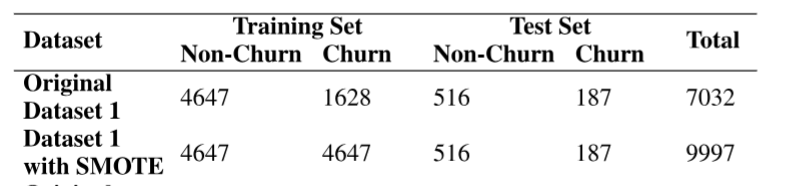

In [23]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from statsmodels import stats

In [14]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Don't truncate column content
np.set_printoptions(threshold=np.inf)  # Show full NumPy arrays


In [15]:
DATA_PATH = os.path.join('../data', 'interim') 
DATASET_PATH = os.path.join(DATA_PATH, 'telco_customer_churn_preprocessed.pkl' )

In [16]:
df = pd.read_pickle(DATASET_PATH)
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,False,True,False,1,False,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,False
1,Male,False,False,False,34,True,No,DSL,Yes,No,Yes,No,No,No,One year,False,Mailed check,56.95,1889.50,False
2,Male,False,False,False,2,True,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,True


In [17]:
bool_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'SeniorCitizen']
category_columns = [
    'gender', 
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'InternetService', 'Contract', 'PaymentMethod'
]
int_columns = ['tenure']
float_columns = ['MonthlyCharges', 'TotalCharges']

len(bool_columns+category_columns+int_columns+float_columns) == len(df.columns)


True

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   bool    
 2   Partner           7032 non-null   bool    
 3   Dependents        7032 non-null   bool    
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   bool    
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   bool    
 16  PaymentMethod     7032 non-nu

# EDA

## Univariate Analysis

Important Notes:
- Target: Class Imbalance
- No rare category or outliers. 
- Total Charges column: left-skewed(handle with log tranform, for parametric ML models).
- Discretizing Float columns for Tree-based models. 

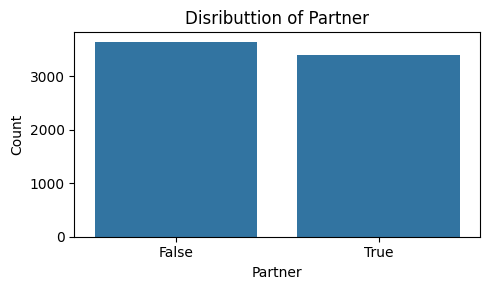

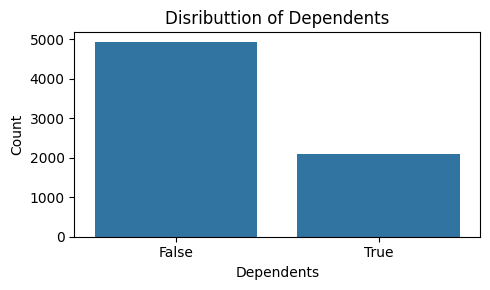

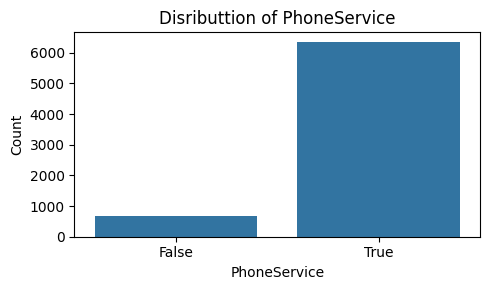

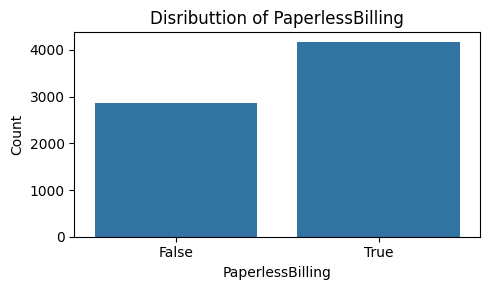

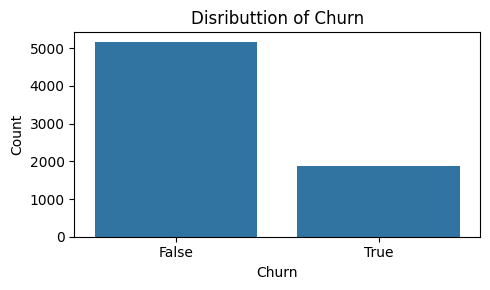

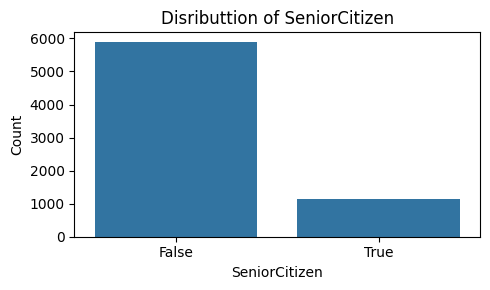

In [19]:
for col in bool_columns:
    plt.figure(figsize=(5, 3))
    sns.countplot(x=col, data=df)
    plt.title(f"Disributtion of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

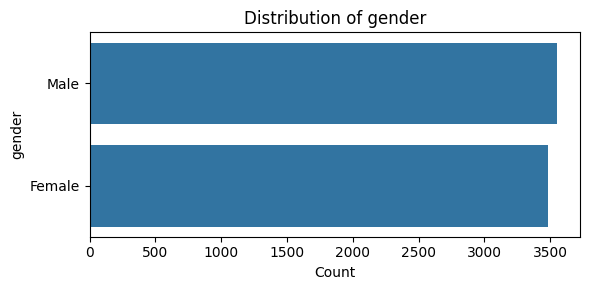

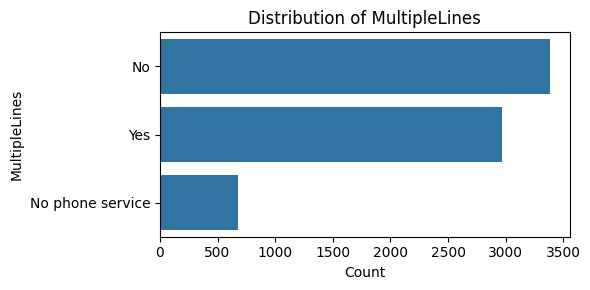

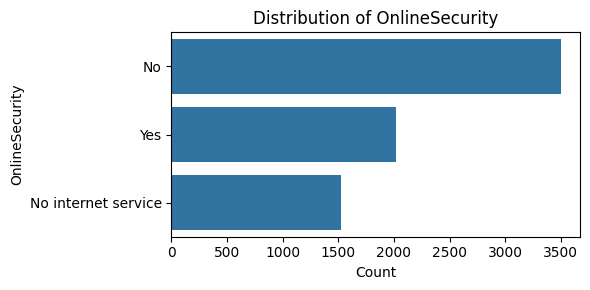

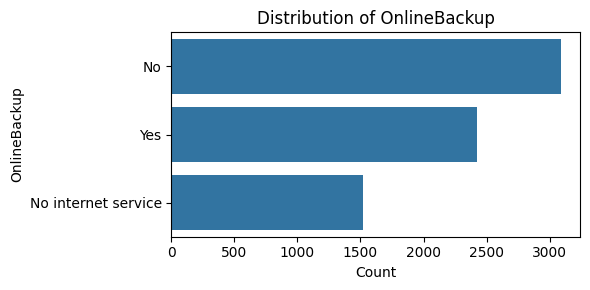

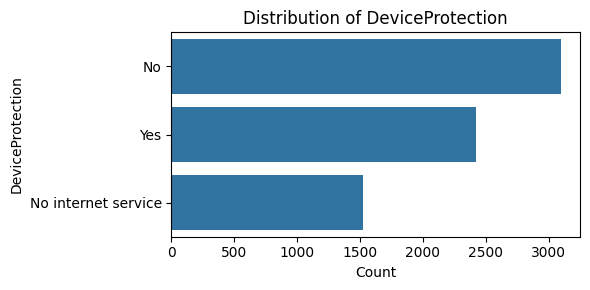

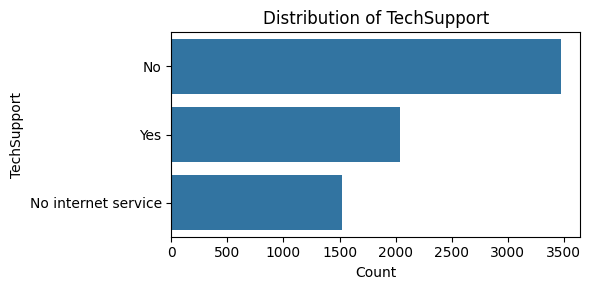

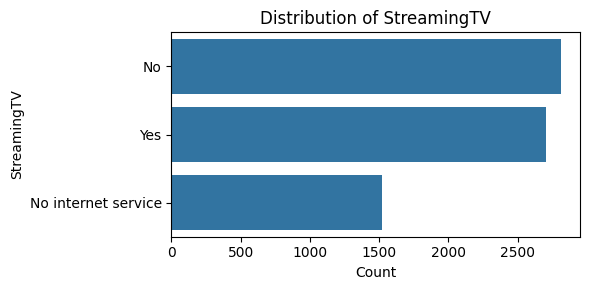

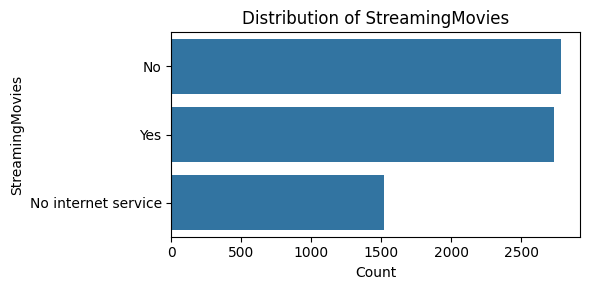

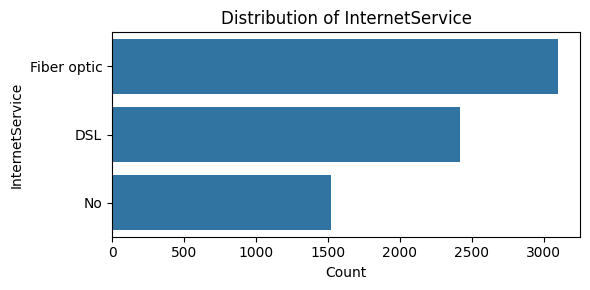

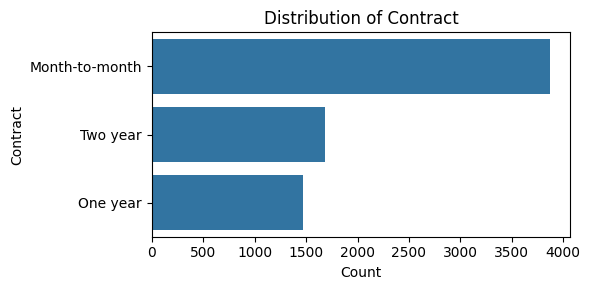

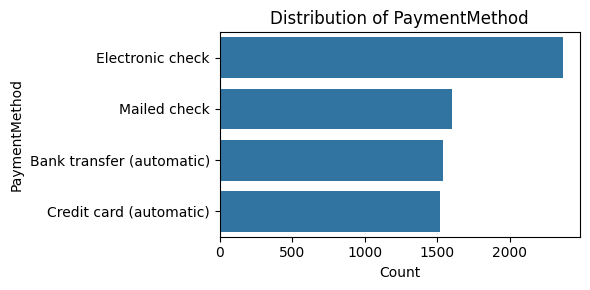

In [21]:
for col in category_columns:
    plt.figure(figsize=(6, 3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


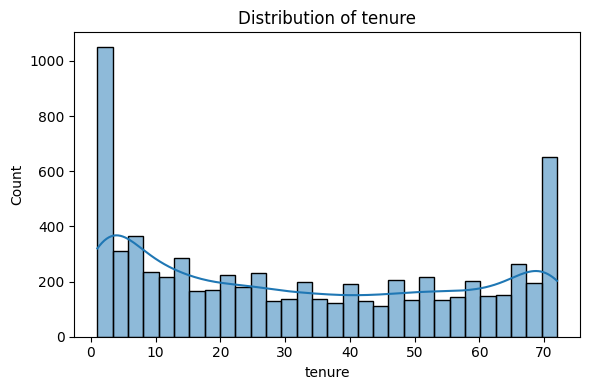

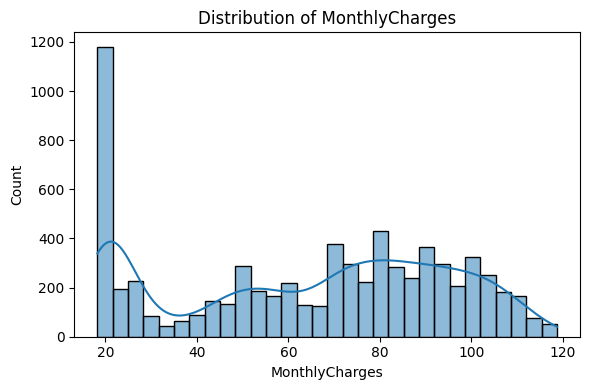

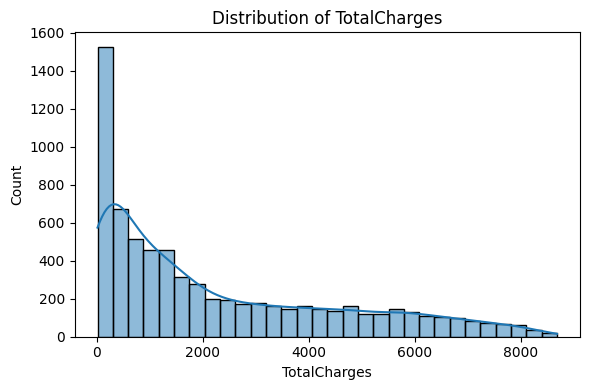

In [22]:
for col in int_columns+float_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## Bivariate Analysis

### Categorical & Boolean Features VS Churn

For each binary or categorical feature:

1 - **Chi-square test** of independence

2 - **Stacked bar chart** of churn proportions by feature level

All test values suggests a statistically significant association witht the target except:
- Gender
- PhoneService

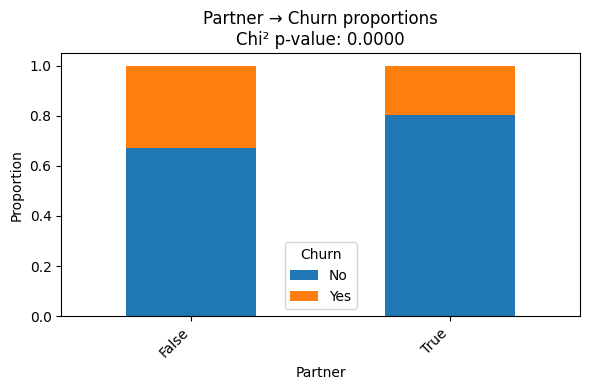

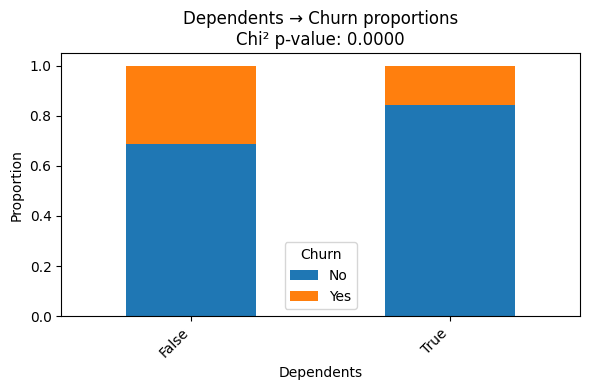

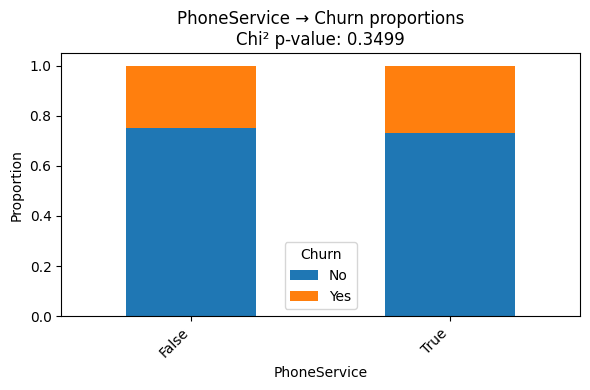

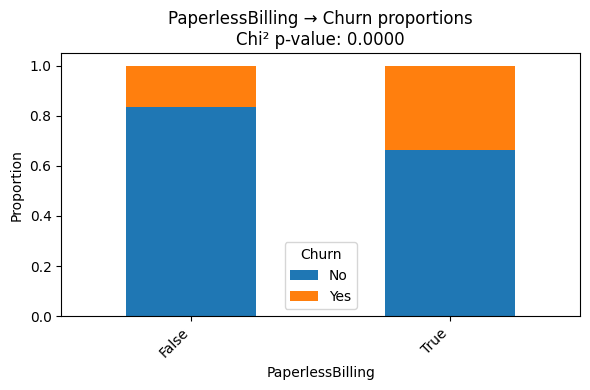

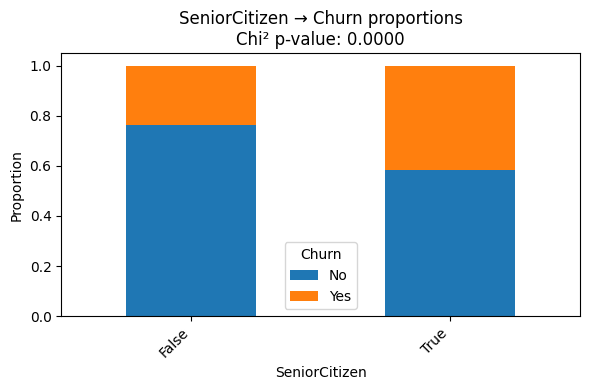

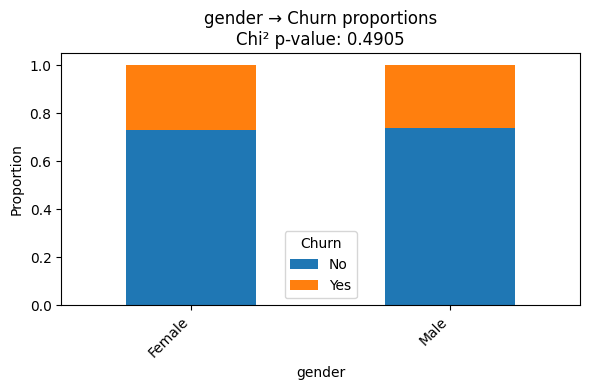

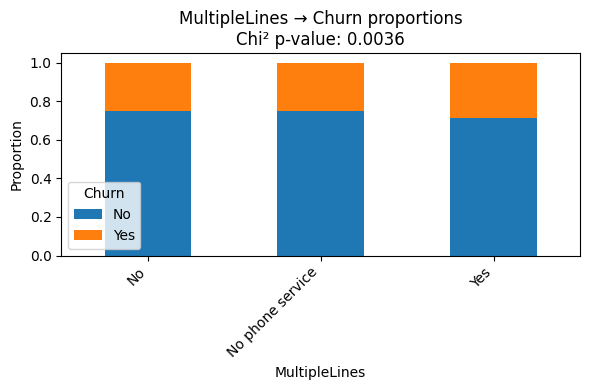

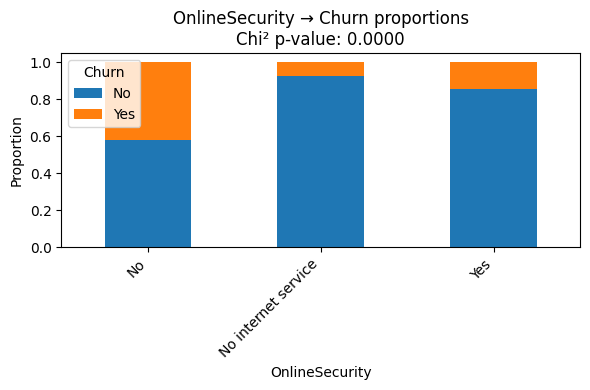

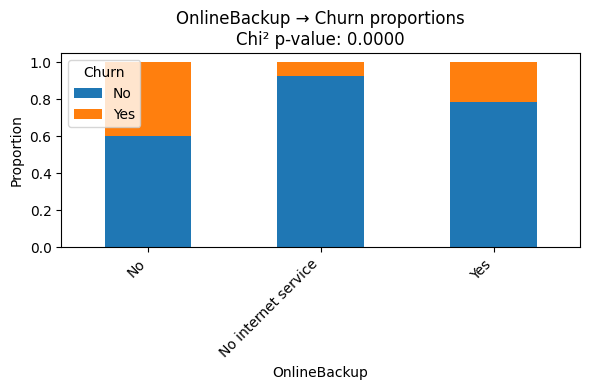

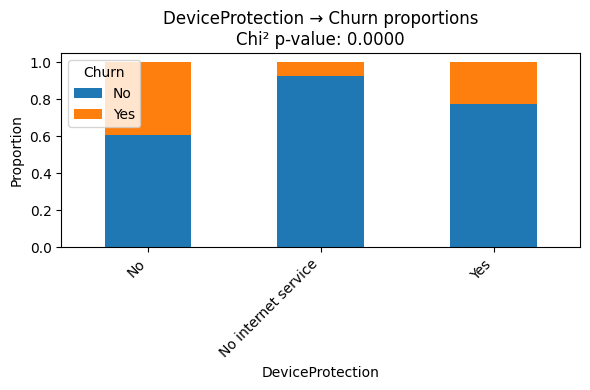

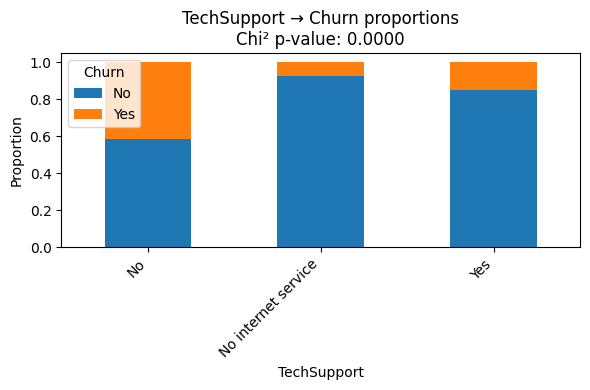

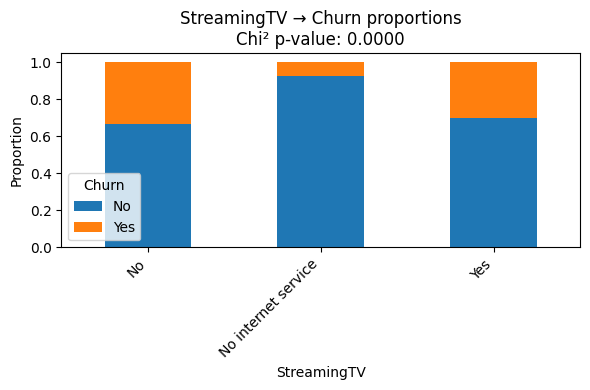

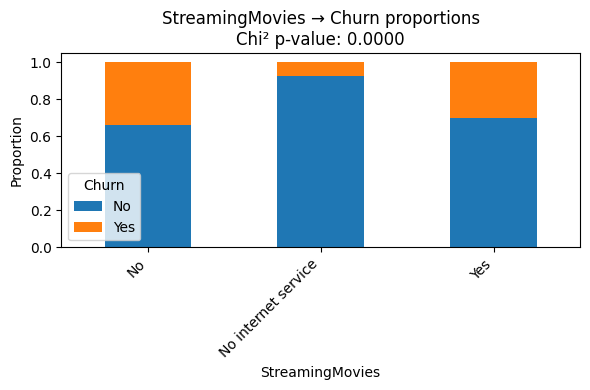

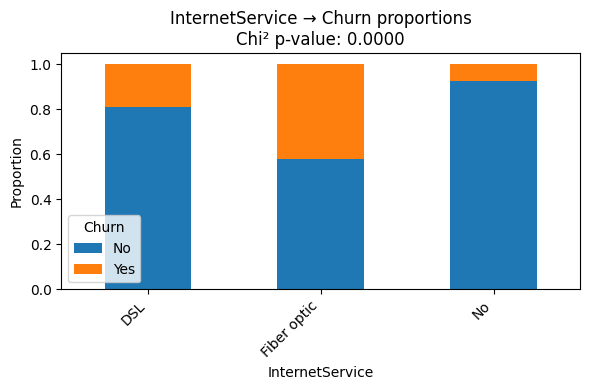

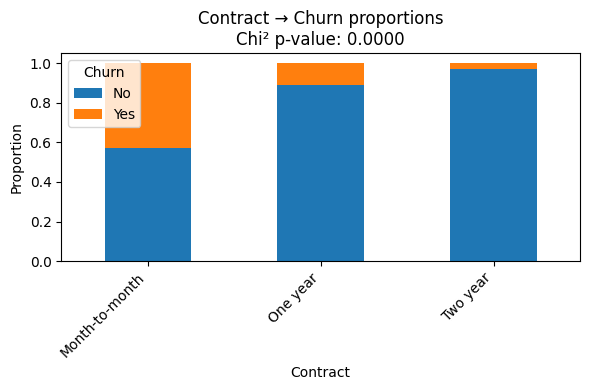

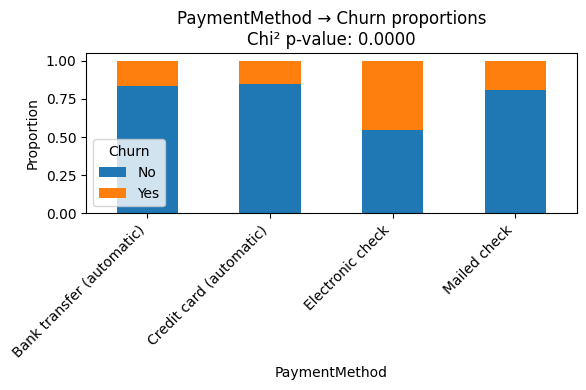

In [25]:
from scipy.stats import chi2_contingency

columns = list(bool_columns + category_columns)
columns.remove('Churn')
for col in columns:
    ct = pd.crosstab(df[col], df['Churn'])
    chi2, p, _, _ = chi2_contingency(ct)

    prop = ct.div(ct.sum(axis=1), axis=0)
    ax = prop.plot(kind='bar', stacked=True, figsize=(6,4))
    
    plt.title(f"{col} → Churn proportions\nChi² p-value: {p:.4f}")
    plt.ylabel("Proportion")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Churn', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()


### Numerical Features VS Churn

t-Test Assumptions:
Two independent groups: matches.
Approximately normal distribution: Shapiro-Wilk test.

In [26]:
from scipy.stats import shapiro

for col in int_columns+float_columns:
    print(f"\n{col} – Normality check:")
    stat_no, p_no = shapiro(df[df['Churn']==False][col])
    stat_yes, p_yes = shapiro(df[df['Churn']==True][col])
    print(f"  No churn: p = {p_no:.4f} | Churn: p = {p_yes:.4f}")



tenure – Normality check:
  No churn: p = 0.0000 | Churn: p = 0.0000

MonthlyCharges – Normality check:
  No churn: p = 0.0000 | Churn: p = 0.0000

TotalCharges – Normality check:
  No churn: p = 0.0000 | Churn: p = 0.0000


c:\Users\Abdelhakiem\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5163.
  res = hypotest_fun_out(*samples, **kwds)


Non of the three numerical features follow normal distribtion. So we instead used Non-Parametric test.

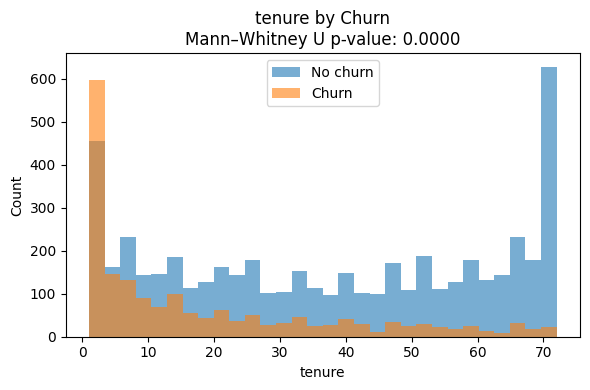

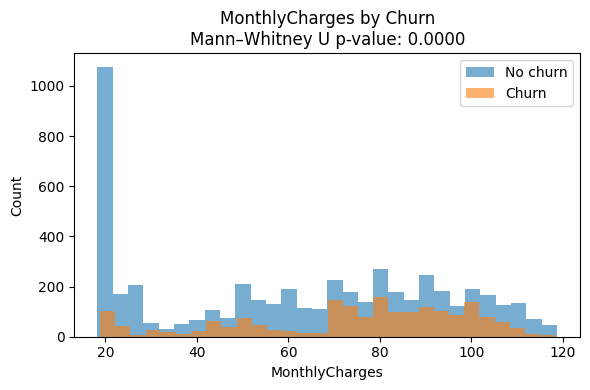

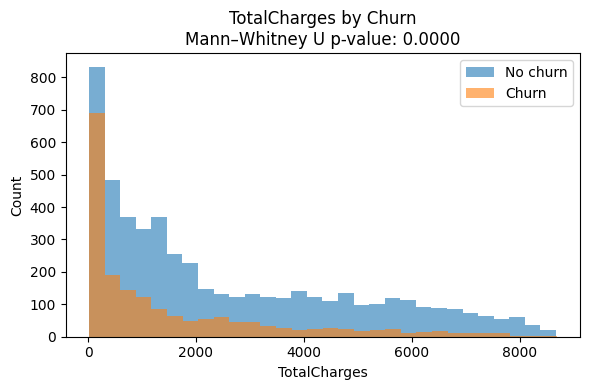

In [28]:
from scipy.stats import mannwhitneyu

for col in int_columns+float_columns:
    group_no  = df[df['Churn'] == False][col].dropna()
    group_yes = df[df['Churn'] == True][col].dropna()
    
    stat, p = mannwhitneyu(group_no, group_yes, alternative='two-sided')

    # Plot
    plt.figure(figsize=(6,4))
    plt.hist(group_no,  bins=30, alpha=0.6, label='No churn')
    plt.hist(group_yes, bins=30, alpha=0.6, label='Churn')
    plt.title(f"{col} by Churn\nMann–Whitney U p-value: {p:.4f}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Colinearity Checking

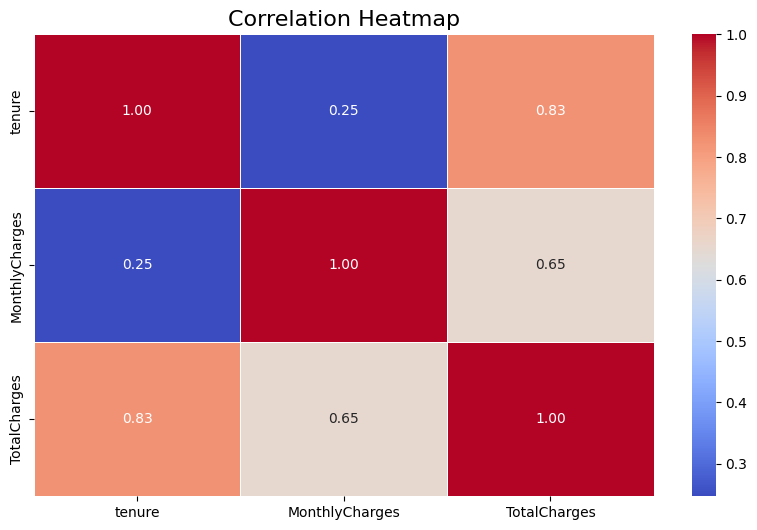

In [29]:
correlation_matrix = df.loc[:,int_columns+float_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title for the heatmap
plt.title("Correlation Heatmap", fontsize=16)

# Show the heatmap
plt.show()

# Data Cleaning

Splitting Data: stratified sampling

Class Imbalance Handling: Upsampling with `SMOTE`

### Parametric Model Pipeline

- Columns to Drop:

`Gender` , `PhoneService` (Nonsignificant relations)

`TotalCharges` (To handle colinearity)


- Data Normalization: 

`tenure` , `Monthly charge`
- Encoding: OHE

### Tree-Based Models Pipeline

- Discretization
- OHE